In [1]:
import torch
import torch.utils.data as Data 
from torch.nn import init
import torch.optim as optim 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np
import time 
import sys
from IPython import display
from matplotlib import pyplot as plt

In [2]:
def set_figsize(figsize = (3.5, 2.5)):
    display.set_matplotlib_formats('svg')
    plt.rcParams['figure.figsize'] = figsize

In [3]:
def xyplot(x_vals, y_vals, name):
    set_figsize(figsize = (5, 2.5))
    plt.plot(x_vals.detach().numpy(), y_vals.detach().numpy())
    plt.xlabel('x')
    plt.ylabel(name + '(x)')

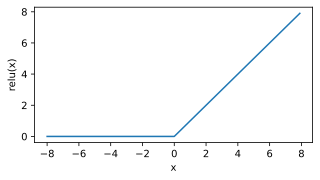

In [4]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad = True)
y = x.relu()
xyplot(x, y, 'relu')

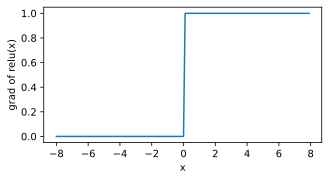

In [10]:
y.sum().backward()
xyplot(x, x.grad, 'grad of relu')

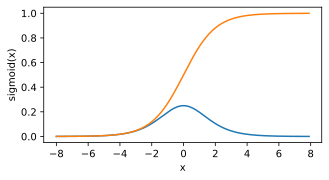

In [15]:
x.grad.data.zero_()
y = x.sigmoid()
y.sum().backward()
xyplot(x, x.grad, 'grad of sigmoid')
xyplot(x, y, 'sigmoid')

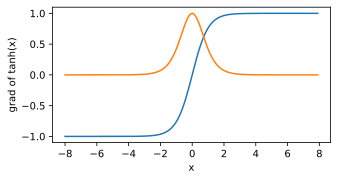

In [16]:
x.grad.zero_()
y = x.tanh()
y.sum().backward()
xyplot(x, y, 'tanh')
xyplot(x, x.grad, 'grad of tanh')

In [5]:
def load_data_fashion_mnist(batch_size):
    mnist_train = torchvision.datasets.FashionMNIST(root = './Dataset/FashionMNIST', train = True, 
                                                    download = True, transform = transforms.ToTensor())
    mnist_test = torchvision.datasets.FashionMNIST(root = './Dataset/FashionMNIST', train = False, 
                                                   download = True, transform = transforms.ToTensor())
    if sys.platform.startswith('win'):
        num_workers = 4
    else:
        num_workers = 0
    train_iter = Data.DataLoader(mnist_train, batch_size = batch_size, shuffle = True, num_workers = num_workers)
    test_iter = Data.DataLoader(mnist_test, batch_size = batch_size, shuffle = True, num_workers = num_workers)
    return train_iter, test_iter

In [6]:
# slice the dataset into train_iter and test_iter
train_iter, test_iter = load_data_fashion_mnist(batch_size = 256)

In [11]:
# initalate the params
n_inputs, n_hiddens, n_outputs = 784, 256, 10 
w1 = torch.tensor(np.random.normal(0, 0.01, (n_inputs, n_hiddens)), dtype = torch.float, requires_grad = True)
b1 = torch.zeros(n_hiddens, dtype = torch.float, requires_grad = True)
w2 = torch.tensor(np.random.normal(0, 0.01, (n_hiddens, n_outputs)), dtype = torch.float, requires_grad = True) 
b2 = torch.zeros(n_outputs, dtype = torch.float, requires_grad = True)

In [12]:
# activation function
def relu(x):
    return torch.max(x, torch.tensor(0.0))

In [13]:
# softmax
def softmax(x):
    x_exp = x.exp()
    partition = x_exp.sum(dim = 1, keepdim = True)
    return x_exp/partition

In [14]:
# model
def network(x, w1, b1, w2, b2):
    x = x.view(x.shape[0], -1)
    H = relu(torch.matmul(x, w1)+b1)
    return softmax(torch.matmul(H, w2)+b2)

In [15]:
# lossfunction
loss_fn = nn.CrossEntropyLoss()

def crossentropy(y_hat, y):
    return (-torch.log(y_hat.gather(1, y.view(-1, 1)))).mean()

In [16]:
#optimizer
def sgd(params, lr):
    for param in params:
        param.data -= lr*param.grad

In [17]:
#正确率评估
def evaluate_accuracy(data_iter, model, params = None):
    acc_sum, n = 0.0, 0
    if params is not None:
        for X, y in data_iter:
            acc_sum += (model(X, *params).argmax(dim=1) == y).float().sum().item()
            n += y.shape[0]
    else:   
        for X, y in data_iter:
            acc_sum += (model(X).argmax(dim=1) ==y).float().sum().item()
            n += y.shape[0]
    return acc_sum/n

In [18]:
def train_ch3(n_epoch, train_iter, test_iter, model, loss_fn, evaluate_accuracy, params = None, lr = None, optimizer = None):
    for epoch in range(n_epoch):
        train_loss_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            if params is not None:
                y_hat = model(X, *params)
            else:
                y_hat = model(X)
            
            loss = loss_fn(y_hat, y)
            
            #梯度清理
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            
            #backpropagation
            loss.backward()
            
            #参数更新
            if optimizer is None:
                sgd(params, lr)
            else:
                optimizer.step()
                
            #train_loss, train_acc
            train_loss_sum += loss.item()
            train_acc_sum += (y_hat.argmax(dim = 1, keepdim = True) == y.view(-1,1)).float().sum().item() 
            n += y.shape[0]
            
        if epoch%5 ==0:
            if params is not None:
                test_acc = evaluate_accuracy(test_iter, model, params)
            else:
                test_acc = evaluate_accuracy(test_iter, model)
            train_acc = train_acc_sum/n
            train_loss = train_loss_sum/n
            print('epoch: %d, train_loss: %.4f, train_acc: %.2f, test_acc: %.2f'%(epoch, train_loss, train_acc, test_acc))

In [20]:
train_ch3(n_epoch = 20, 
          train_iter = train_iter, test_iter = test_iter, 
          model = network, loss_fn = loss_fn, evaluate_accuracy = evaluate_accuracy, 
          params = [w1, b1, w2, b2], lr = 0.1, optimizer = None)

epoch: 0, train_loss: 0.0071, train_acc: 0.68, test_acc: 0.68
epoch: 5, train_loss: 0.0066, train_acc: 0.78, test_acc: 0.78
epoch: 10, train_loss: 0.0066, train_acc: 0.80, test_acc: 0.79
epoch: 15, train_loss: 0.0065, train_acc: 0.81, test_acc: 0.80


In [4]:
points = torch.tensor([[1.0, 4.0], [2.0, 1.0], [3.0, 5.0]])
second_point = points[1].clone()


In [6]:
second_point[0] = 10.0


tensor([10.,  1.])

In [7]:
points_t = points.t()
points_t

tensor([[1., 2., 3.],
        [4., 1., 5.]])

In [8]:
points.storage()

 1.0
 4.0
 2.0
 1.0
 3.0
 5.0
[torch.FloatStorage of size 6]

In [18]:
points = torch.tensor([[1.0, 4.0], [2.0, 1.0], [3.0, 5.0]])
points_t = points.t()
points_t

tensor([[1., 2., 3.],
        [4., 1., 5.]])

In [19]:
points_t_cont = points_t.contiguous()
points_t_cont

tensor([[1., 2., 3.],
        [4., 1., 5.]])

In [21]:
points.storage()

 1.0
 4.0
 2.0
 1.0
 3.0
 5.0
[torch.FloatStorage of size 6]

In [20]:
points_t_cont.storage()

 1.0
 2.0
 3.0
 4.0
 1.0
 5.0
[torch.FloatStorage of size 6]